# Linear Regression - Bike Sharing Assignment

## Problem Statement
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free.

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. BoomBikes aspires to understand the demand for shared bikes among the people after the ongoing quarantine situation ends across the nation due to Covid-19. *They want to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market.* 

The company wants to know:
- Which variables are significant in predicting the demand for shared bikes?
- How well those variables describe the bike demands?

## Business Goal:
In this assignment, model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

### Step 1: Import Required Libraries

In [245]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [246]:
import numpy as np
import pandas as pd

# Set max_rows and max_columns to be displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns

## Linear Regression modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

### Step 2: Reading and Understanding the data

In [248]:
df_orig = pd.read_csv('day.csv')

In [249]:
df_orig.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [250]:
print("The daily bike sharing dataset has {} rows and {} columns.".format(df_orig.shape[0], df_orig.shape[1]))

The daily bike sharing dataset has 730 rows and 16 columns.


In [251]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [252]:
df_orig.isnull().mean()

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

**There are no null values in the dataset.**
#### Removing duplicates

In [254]:
df_orig = df_orig.drop_duplicates()

**After removing duplicates, the daily bike sharing dataset still has 730 rows and 16 columns. Hence, no duplicates.**

#### Verifying if dteday column can be dropped. 
- Number of rows should be 0 for extracted year from 'dteday' not matching 'yr' column
- Number of rows should be 0 for extracted month from 'dteday' not matching 'mnth' column

In [257]:
print(df_orig[df_orig.yr != df_orig.dteday.apply(lambda x: 0 if x[-4:]=='2018' else 1)].shape)
print(df_orig[df_orig.mnth != df_orig.dteday.apply(lambda x: x[3:5]).astype('int64')].shape)

(0, 16)
(0, 16)


Removing following columns from the dataset:
1. instant - Its the record index & unique for each row. Will not contribute in our modeling.
2. dteday - We already have year and month in separate columns. Will not contribute anything new.
3. casual & registered - 'cnt' already includes the sum of these fields. We have to understand how the **total** number of daily bikes rentals is affected based on other parameters.

In [259]:
df_new = df_orig.drop(['instant','dteday','casual','registered'],axis=1)

In [260]:
print("The daily bike sharing dataset now has {} rows and {} columns.".format(df_new.shape[0], df_new.shape[1]))

The daily bike sharing dataset now has 730 rows and 12 columns.


#### Number of unique values per column in the dataset

In [262]:
for i in df_new.columns:
    print(i, df_new[i].nunique())

season 4
yr 2
mnth 12
holiday 2
weekday 7
workingday 2
weathersit 3
temp 498
atemp 689
hum 594
windspeed 649
cnt 695


#### Dividing columns into numerical & categorical

In [264]:
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

### Step 3: Data Visualisation & EDA

#### Outlier analysis

In [267]:
Q1=df_new["hum"].quantile(0.25)
Q3=df_new["hum"].quantile(0.75)

IQR=Q3-Q1
lower_range=Q1-1.5*IQR
upper_range=Q3+1.5*IQR

outlier_IQR=df_new[(df_new["hum"]<lower_range)| (df_new["hum"]>upper_range)]

outlier_IQR

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
49,1,0,2,0,6,0,1,16.365847,19.5702,18.7917,34.000021,1635
68,1,0,3,0,4,1,3,15.952731,19.2834,0.0000,17.545759,623


In [268]:
df_new.drop(index=[49,68], inplace=True)
df_new.shape

(728, 12)

In [269]:
Q1=df_new["windspeed"].quantile(0.25)
Q3=df_new["windspeed"].quantile(0.75)

IQR=Q3-Q1
lower_range=Q1-1.5*IQR
upper_range=Q3+1.5*IQR

outlier_IQR=df_new[(df_new["windspeed"]<lower_range)| (df_new["windspeed"]>upper_range)]

outlier_IQR.index

Index([44, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720], dtype='int64')

In [270]:
df_new.drop(index=[44, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720], inplace=True)
df_new.shape

(716, 12)

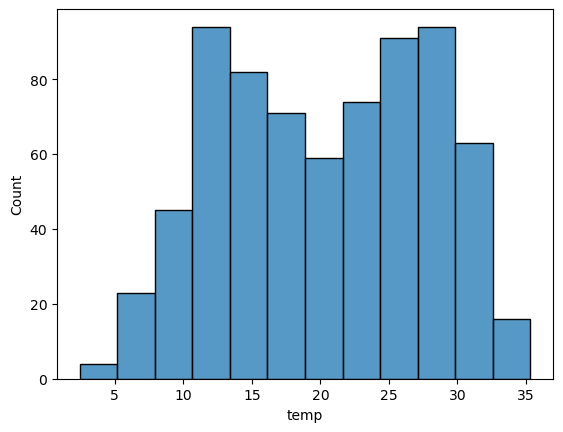

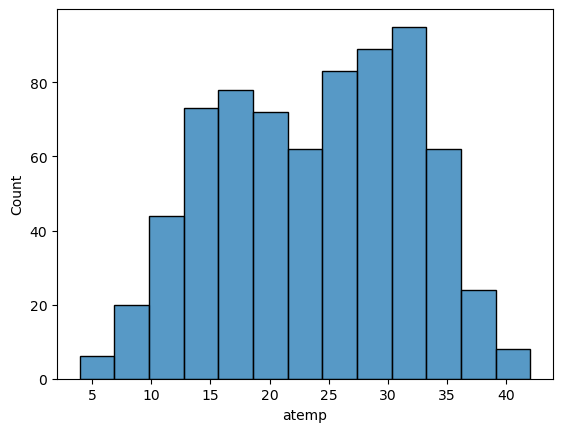

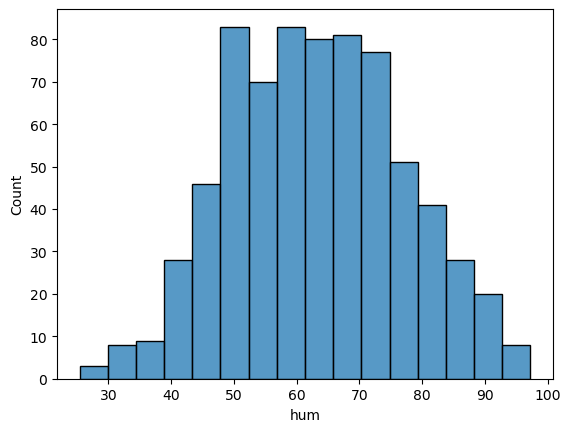

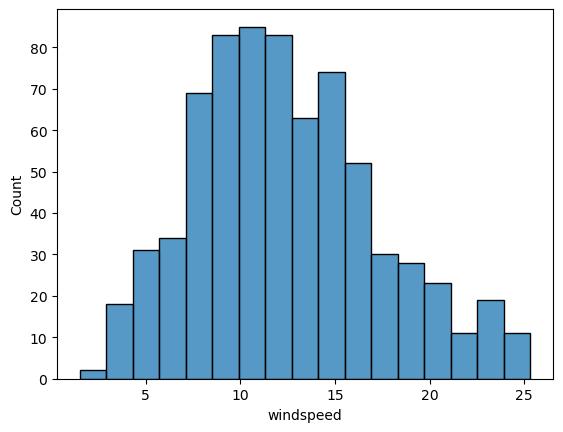

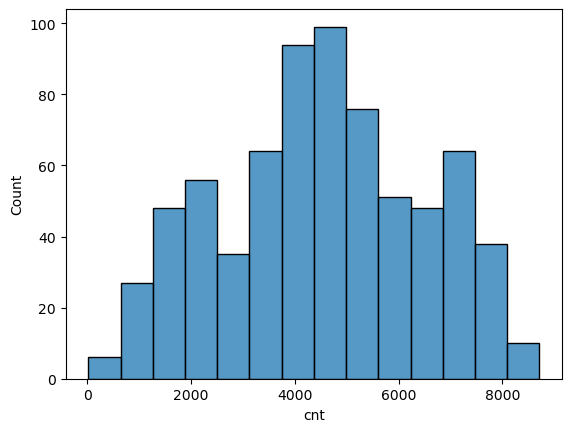

In [271]:
# Univariate analysis on numerical columns using histogram
for i in numerical_columns:
    sns.histplot(data=df_new[i])
    plt.show()

**Conclusion**: The distribution above shows most of the data in the middle range of our of the numerical parameters.

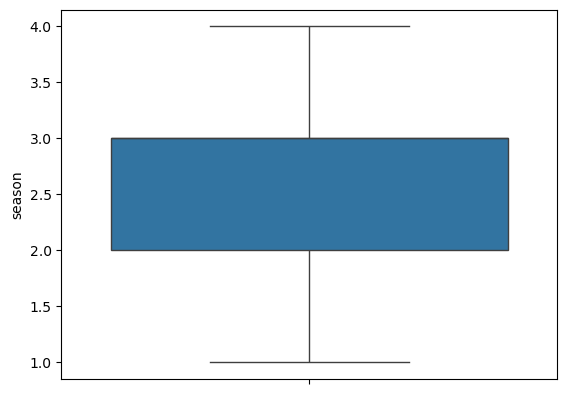

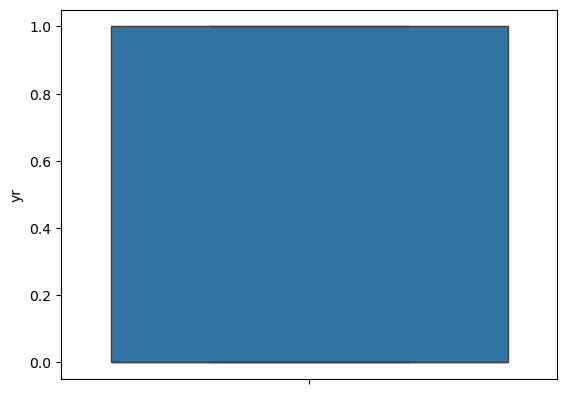

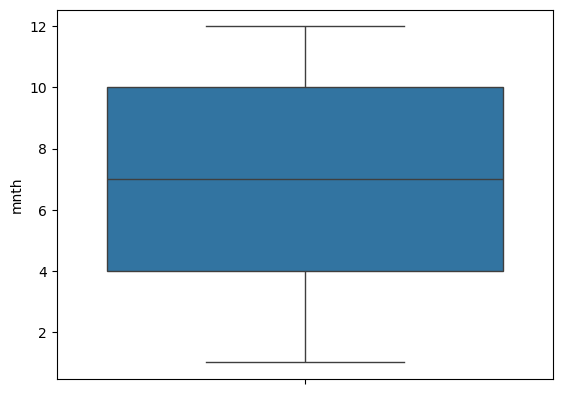

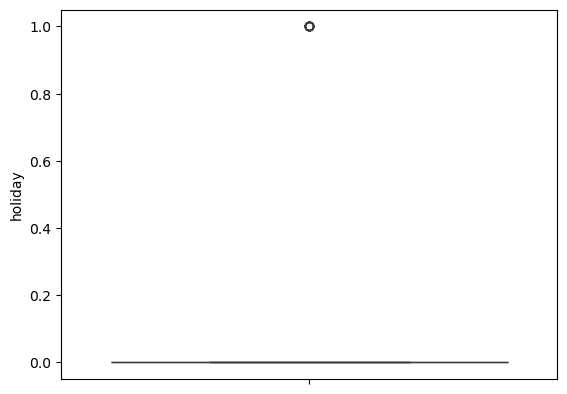

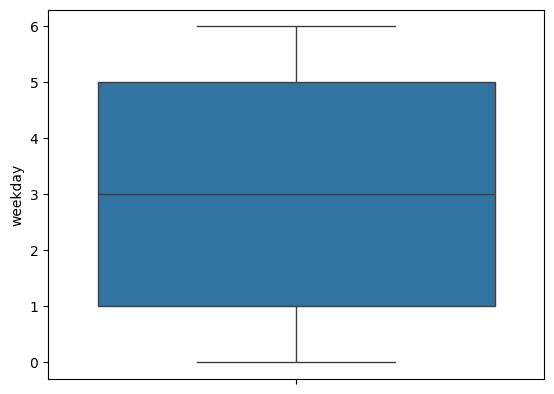

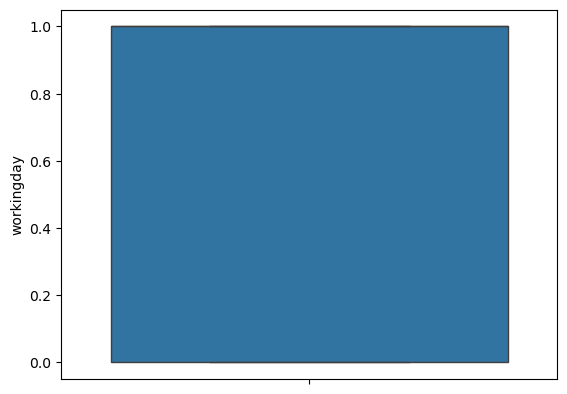

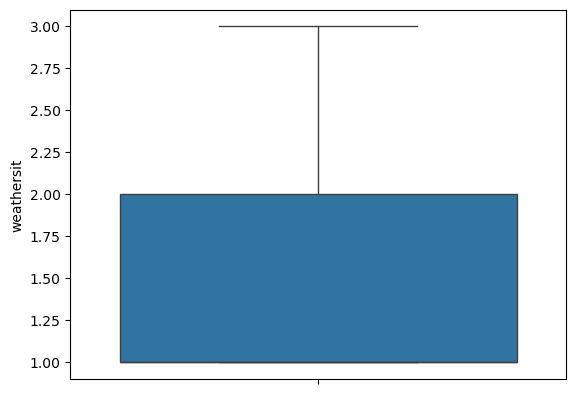

In [273]:
# Univariate analysis on categorical columns using boxplot
for i in categorical_cols:
    sns.boxplot(data=df_new[i])
    plt.show()

**Conclusion**: The box plot for categorical columns above shows that there are no outliers. Except the holiday column but it only takes 2 values - 0 & 1. Hence, no need of any cleaning. 

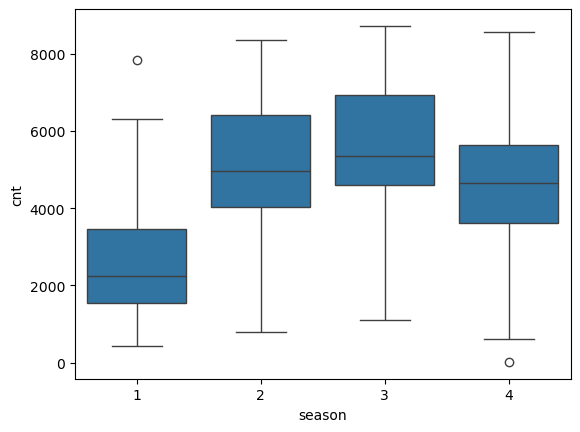

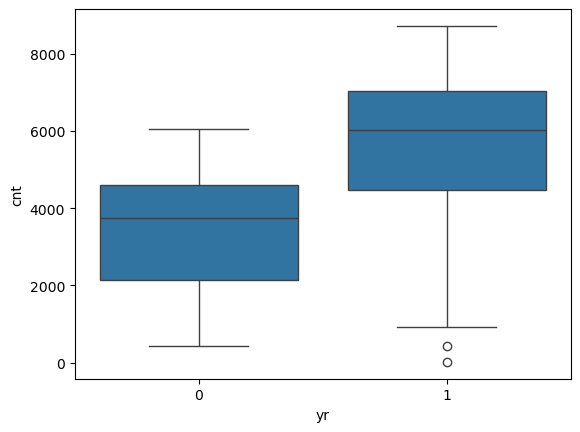

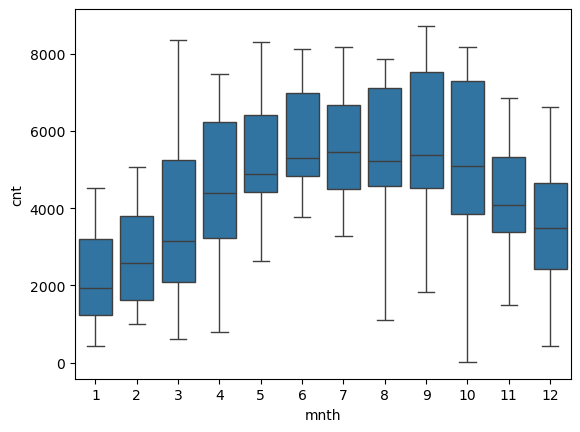

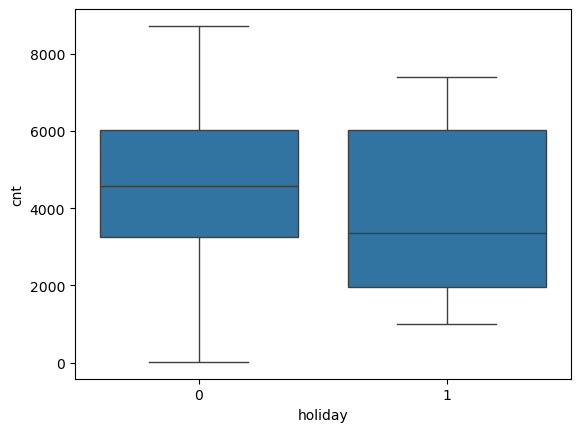

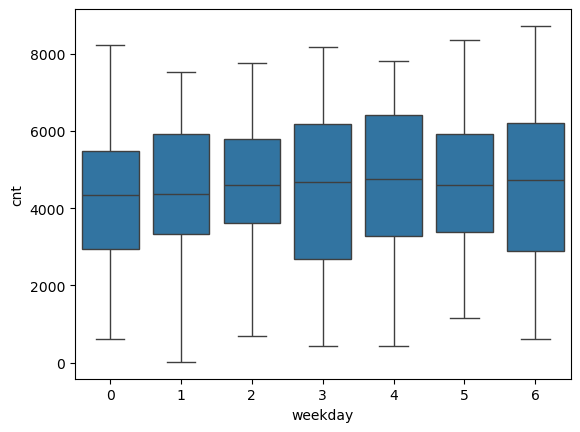

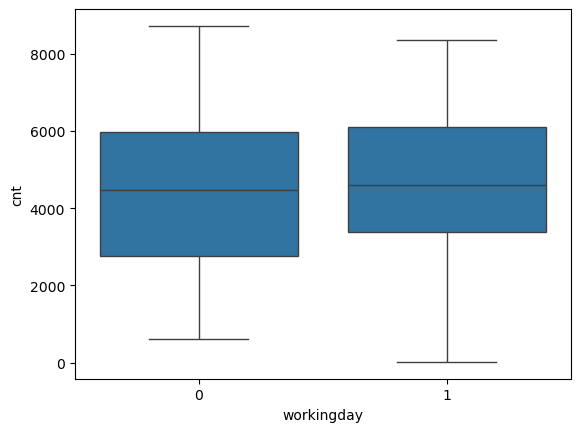

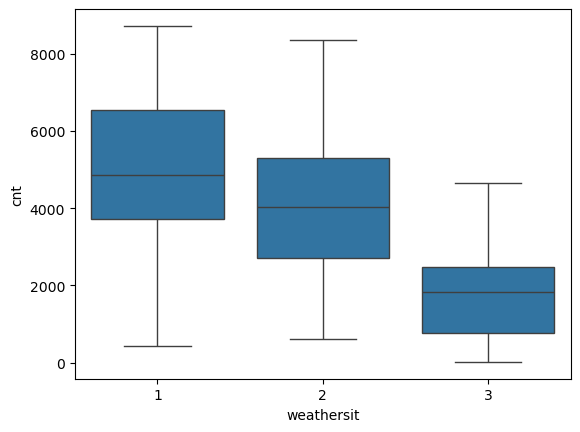

In [275]:
# Bivariate analysis on categorical columns vs cnt using boxplot
for i in categorical_cols:
    sns.boxplot(data=df_new, x=df_new[i], y=df_new['cnt'])
    plt.show()

**Conclusion**: 
1. Season vs cnt - Summer(2), Fall(3) & Winter(4) sees more number of bike rentals as compared to the spring(1). There minimum bike rentals is more than the 75 percentile of spring season's bike rental count.
2. Year vs cnt - The minimum bike rentals in 2019 were approximately equal to the 75th percentile of 2018's bike rental count.
3. mnth vs cnt - Months 4-11 (April-November) shows the distribution of bike rentals on the higher end. This can be because the weather is good during this time.
4. Holiday vs cnt - On a non-holiday, the max bike rentals reaches around 8K. Though, the minimum is higher on a holiday as compared to non-holiday.
5. Weekday vs cnt - The median bike rentals is around the same range on all the days of the week. On Saturday, the rentals are maximum & on mondays the rentals are minimum. {0 - Sunday ... , 6 - Saturday}. 
6. Workingday vs cnt - Minimum on a working day can reach around 0.
7. Weathersit vs cnt - On a clear day, 75% of the rentals are in the range of ~500-6300 as compared to ~2000 & less on a rainy day.
   - 1: Clear, Few clouds, Partly cloudy, Partly cloudy,
   - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist,
   - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

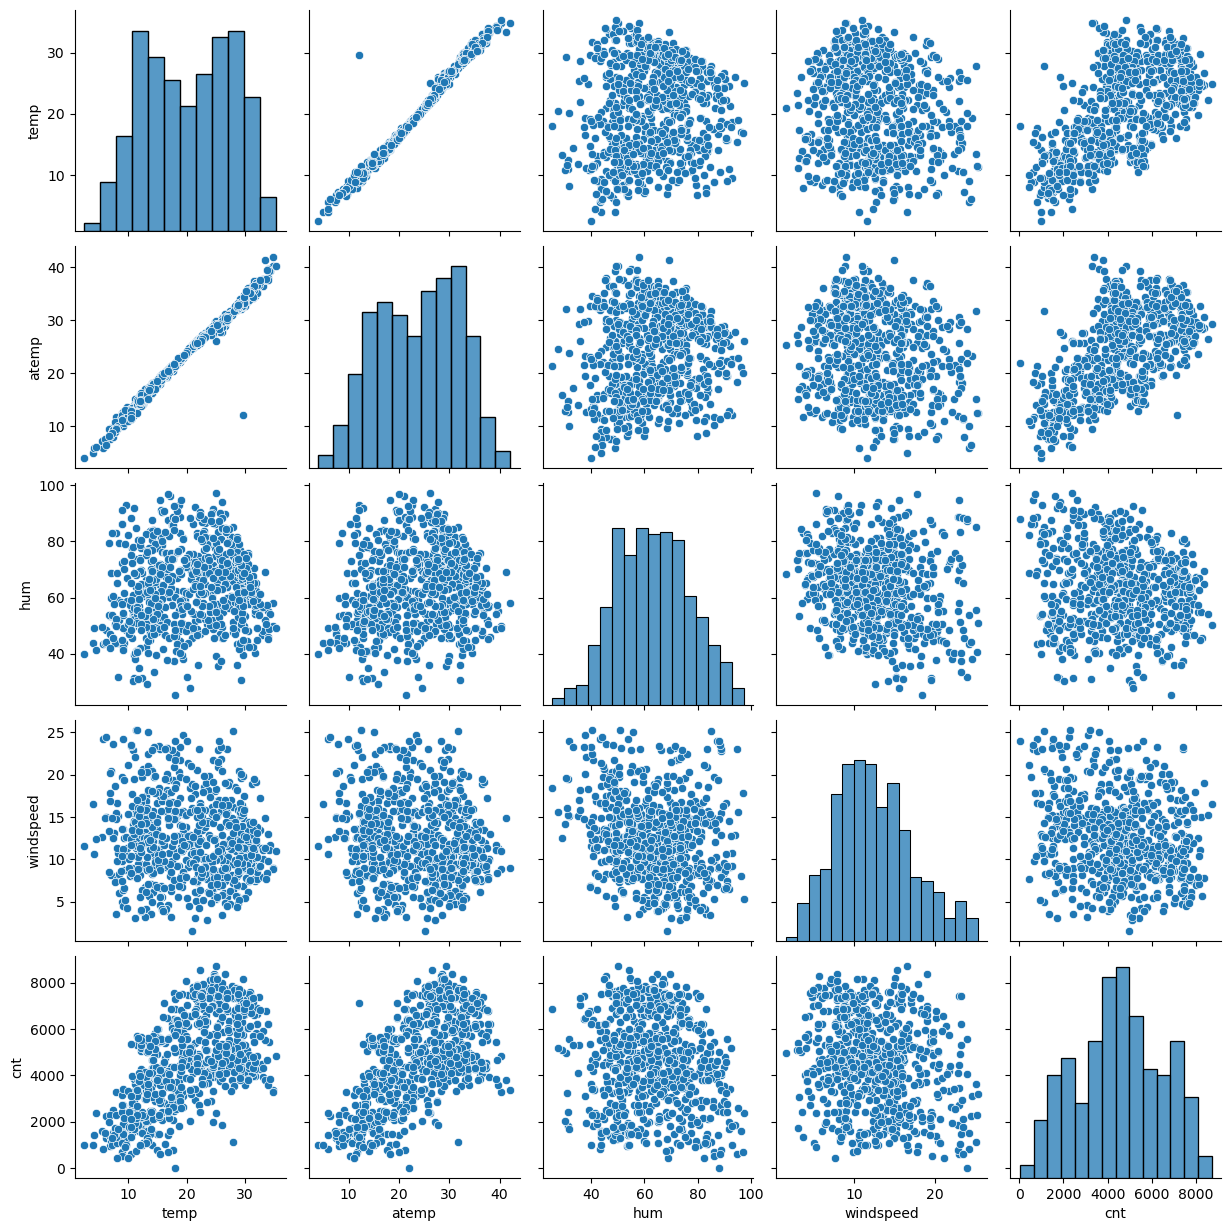

In [277]:
# Bivariate analysis of numerical columns
sns.pairplot(df_new, x_vars=numerical_columns, y_vars=numerical_columns)
plt.show()

**Conclusion**: 
1. temp vs atemp - There is a strong correlation between the 2 variables as shown above. These 2 fields have a strong collinearity.
2. cnt vs temp / cnt vs atemp - There seems to be some positive relation between temperature and number of bike rentals in a day.

- *Correlation matrix between all the numerical parameters also aligns with the above conclusion*

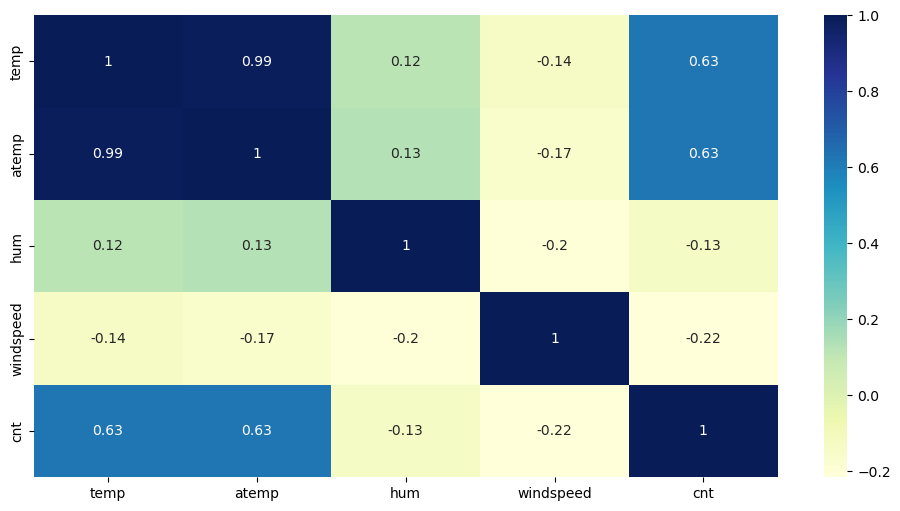

In [279]:
plt.figure(figsize=(12,6))
sns.heatmap(df_new[numerical_columns].corr(), annot=True, cmap="YlGnBu")
plt.show()

### Step 4: Data Pre-processing
- This includes creation of dummy variables for categorical variables with more than 2 unique values.
- This is also called One-Hot Encoding.

In [281]:
df_new.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [282]:
for i in categorical_cols:
    print(i , df_new[i].nunique())

season 4
yr 2
mnth 12
holiday 2
weekday 7
workingday 2
weathersit 3


In [283]:
df_new.season = df_new.season.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df_new.mnth = df_new.mnth.map({1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug',9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'})
df_new.weekday = df_new.weekday.map({0: 'sun', 1: 'mon', 2: 'tues', 3: 'wed', 4: 'thu', 5: 'fri', 6: 'sat'})
df_new.weathersit = df_new.weathersit.map({1: 'clear', 2: 'cloudy', 3: 'lightRain', 4: 'heavyRain'})

#### Dummy Variables

In [285]:
# Following categorical variables have more than 2 unique values 
# and needs dummy columns to be created
dummy_to_be_created = ['season', 'mnth', 'weekday', 'weathersit']

*Not dropping first dummy column for 'weathersit' because the training dataset only contains 3 types of weather but the test data may have 4th type present.*

In [287]:
df_new = pd.get_dummies(df_new, columns=['season', 'mnth', 'weekday'], drop_first=True, dtype=int)
df_new = pd.get_dummies(df_new, columns=['weathersit'], dtype=int)

In [288]:
df_new.shape

(716, 31)

In [289]:
print("After dummy variable creation, the daily bike sharing dataset now has {} rows and {} columns.".format(df_new.shape[0], df_new.shape[1]))

After dummy variable creation, the daily bike sharing dataset now has 716 rows and 31 columns.


In [290]:
df_new.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [291]:
df_new.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000
mean,0.498603,0.029330,0.684358,20.400717,23.821520,63.132034,12.481868,4536.613128,0.238827,0.252793,0.245810,0.086592,0.085196,0.072626,0.085196,0.086592,0.083799,0.081006,0.086592,0.083799,0.083799,0.083799,0.142458,0.142458,0.143855,0.141061,0.143855,0.142458,0.632682,0.339385,0.027933
std,0.500348,0.168847,0.465096,7.529887,8.159941,13.916864,4.812977,1932.256146,0.426665,0.434917,0.430867,0.281433,0.279368,0.259703,0.279368,0.281433,0.277280,0.273034,0.281433,0.277280,0.277280,0.277280,0.349764,0.349764,0.351188,0.348328,0.351188,0.349764,0.482411,0.473832,0.164896
min,0.000000,0.000000,0.000000,2.424346,3.953480,25.416700,1.500244,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.828962,16.894537,52.458300,8.989859,3214.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,20.739153,24.605200,63.083300,11.958797,4572.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.931885,30.556050,73.260425,15.458374,6031.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,25.333236,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Step 5: Splitting the Data into Training and Testing Sets

The first basic step for regression is to perform a train-test split on the dataset. I am splitting the data with train size of 70%.

In [293]:
np.random.seed(0)
df_train, df_test = train_test_split(df_new, train_size = 0.7, test_size = 0.3, random_state = 100)

In [294]:
print(df_train.shape)
print(df_test.shape)

(501, 31)
(215, 31)


### Step 6: Rescaling the Features

It is important to scale the features so that the coefficients obtained by fitting the regression model are not very large or very small when compared. Its advisable to standardise or normalise our dataset so that the coefficients obtained are on the same scale. There are 2 common ways to scale -> Min-Max Scaling and Standardisation.

For this assignment, I am going to use **Min-Max scaling** which will scale the features using the formula - (x-xmin)/(xmax-xmin), where x is a series of values in a column. This way all values are between 0 and 1.

In [296]:
scaler = MinMaxScaler()

In [297]:
#Only following columns need scaling
numerical_columns

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

- Apply the scaling on both training and test data sets.
- We use fit and transform on the training data.
- "Fit" basically Learns categories & "transform" converts categories to numbers using learned mapping.
- On the test data, we only do a transform to scale it based on the mapping learnt using training data.

In [299]:
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

In [300]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
728,1,0,0,0.252441,0.204242,0.293114,0.923102,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
541,1,0,1,0.733702,0.689995,0.126342,0.914353,0.853659,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
116,0,0,1,0.719799,0.663818,0.826912,0.814718,0.442936,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
718,1,0,1,0.347624,0.342763,0.572964,0.309436,0.472388,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
496,1,0,0,0.648145,0.623239,0.288693,0.283207,0.852163,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [301]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.00000,501.000000,501.000000,501.000000,501.000000,501.000000,501.00000,501.00000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,0.504990,0.031936,0.682635,0.555826,0.524299,0.519049,0.461956,0.519573,0.241517,0.241517,0.245509,0.087824,0.08982,0.065868,0.091816,0.087824,0.069860,0.085828,0.08982,0.08982,0.077844,0.087824,0.159681,0.141717,0.143713,0.139721,0.129741,0.141717,0.610778,0.365269,0.023952
std,0.500475,0.176006,0.465916,0.235899,0.218363,0.210216,0.206848,0.226255,0.428431,0.428431,0.430819,0.283322,0.28621,0.248300,0.289055,0.283322,0.255166,0.280390,0.28621,0.28621,0.268194,0.283322,0.366676,0.349108,0.351149,0.347043,0.336354,0.349108,0.488061,0.481987,0.153053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.343347,0.328399,0.363234,0.316427,0.358836,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.558310,0.539587,0.520530,0.431828,0.522434,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.766857,0.707754,0.674036,0.585673,0.692706,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [302]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
583,1,0,1,0.868455,0.827713,0.627290,0.265707,0.834215,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
493,1,0,1,0.662048,0.634223,0.688567,0.545436,0.540152,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
294,0,0,0,0.466335,0.463565,0.514214,0.197559,0.493097,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
157,0,0,1,0.832094,0.771951,0.466836,0.465023,0.553497,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
670,1,0,1,0.379708,0.370630,0.351863,0.685331,0.670156,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Step 7: Modeling

#### 7.1 Dividing training dataframe into X and Y sets for the model building

In [305]:
y_train = df_train.pop('cnt')
X_train = df_train

In [306]:
print(y_train.shape)
print(X_train.shape)

(501,)
(501, 30)


In [307]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tues,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_lightRain
728,1,0,0,0.252441,0.204242,0.293114,0.923102,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
541,1,0,1,0.733702,0.689995,0.126342,0.914353,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
116,0,0,1,0.719799,0.663818,0.826912,0.814718,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
718,1,0,1,0.347624,0.342763,0.572964,0.309436,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
496,1,0,0,0.648145,0.623239,0.288693,0.283207,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


#### 7.2 Feature Selection using Recursive feature elimination (RFE)
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached.

In [309]:
# Running RFE with the output number of the variable equal to 16
# since total number of columns in training data set = 29
linear_model_1 = LinearRegression()
linear_model_1.fit(X_train, y_train)

rfe_1 = RFE(linear_model_1, n_features_to_select=16)             # running RFE
rfe_1 = rfe_1.fit(X_train, y_train)

In [310]:
# List of columns and if they are selected using RFE
list(zip(X_train.columns,rfe_1.support_,rfe_1.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', False, 14),
 ('season_spring', True, 1),
 ('season_summer', False, 13),
 ('season_winter', True, 1),
 ('mnth_aug', False, 11),
 ('mnth_dec', False, 2),
 ('mnth_feb', False, 4),
 ('mnth_jan', True, 1),
 ('mnth_jul', False, 5),
 ('mnth_jun', False, 15),
 ('mnth_mar', False, 10),
 ('mnth_may', False, 3),
 ('mnth_nov', True, 1),
 ('mnth_oct', False, 6),
 ('mnth_sep', True, 1),
 ('weekday_mon', False, 7),
 ('weekday_sat', True, 1),
 ('weekday_sun', True, 1),
 ('weekday_thu', False, 8),
 ('weekday_tues', False, 9),
 ('weekday_wed', False, 12),
 ('weathersit_clear', True, 1),
 ('weathersit_cloudy', True, 1),
 ('weathersit_lightRain', True, 1)]

In [311]:
# Features selected using RFE
selected_features = X_train.columns[rfe_1.support_]
print(selected_features)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'season_spring',
       'season_winter', 'mnth_jan', 'mnth_nov', 'mnth_sep', 'weekday_sat',
       'weekday_sun', 'weathersit_clear', 'weathersit_cloudy',
       'weathersit_lightRain'],
      dtype='object')


In [312]:
# Features that are not selected using RFE
X_train.columns[~rfe_1.support_]

Index(['windspeed', 'season_summer', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_oct',
       'weekday_mon', 'weekday_thu', 'weekday_tues', 'weekday_wed'],
      dtype='object')

#### 7.3 Creating train data with RFE selected features

In [314]:
X_train_selected = X_train[selected_features]
X_train_selected.head()

,yr,holiday,workingday,temp,atemp,hum,season_spring,season_winter,mnth_jan,mnth_nov,mnth_sep,weekday_sat,weekday_sun,weathersit_clear,weathersit_cloudy,weathersit_lightRain
728,1,0,0,0.252441,0.204242,0.293114,1,0,0,0,0,0,1,1,0,0
541,1,0,1,0.733702,0.689995,0.126342,0,0,0,0,0,0,0,1,0,0
116,0,0,1,0.719799,0.663818,0.826912,0,0,0,0,0,0,0,0,1,0
718,1,0,1,0.347624,0.342763,0.572964,0,1,0,0,0,0,0,0,1,0
496,1,0,0,0.648145,0.623239,0.288693,0,0,0,0,0,1,0,1,0,0


In [315]:
X_train_selected.shape

(501, 16)

#### 7.4 Building model using statsmodel, for the detailed statistics

In [317]:
# Adding a constant variable 

X_train_selected = sm.add_constant(X_train_selected)

In [318]:
X_train_selected.head()

,const,yr,holiday,workingday,temp,atemp,hum,season_spring,season_winter,mnth_jan,mnth_nov,mnth_sep,weekday_sat,weekday_sun,weathersit_clear,weathersit_cloudy,weathersit_lightRain
728,1.0,1,0,0,0.252441,0.204242,0.293114,1,0,0,0,0,0,1,1,0,0
541,1.0,1,0,1,0.733702,0.689995,0.126342,0,0,0,0,0,0,0,1,0,0
116,1.0,0,0,1,0.719799,0.663818,0.826912,0,0,0,0,0,0,0,0,1,0
718,1.0,1,0,1,0.347624,0.342763,0.572964,0,1,0,0,0,0,0,0,1,0
496,1.0,1,0,0,0.648145,0.623239,0.288693,0,0,0,0,0,1,0,1,0,0


In [319]:
X_train_selected.shape

(501, 17)

In [320]:
# Running the linear model
linear_model_2 = sm.OLS(y_train,X_train_selected).fit()   
print(linear_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     185.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          7.52e-185
Time:                        23:12:00   Log-Likelihood:                 497.42
No. Observations:                 501   AIC:                            -964.8
Df Residuals:                     486   BIC:                            -901.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0734 

**Conclusion**
- The overall model has a Probability (F-statistic) = 7.52e-185 which is less than 0.05. This implies our model is significant.
- The features weekday_sun has greater than 0.05 p-value and hence is not as significant.

*Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).
We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information.*

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [324]:
# Calculate the VIFs for the model

def calculate_vif(X_train_selected):
    vif = pd.DataFrame()
    vif['Features'] = X_train_selected.columns
    vif['VIF'] = [variance_inflation_factor(X_train_selected.values, i) for i in range(X_train_selected.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    
    return vif

In [325]:
calculate_vif(X_train_selected)

,Features,VIF
16,weathersit_lightRain,inf
12,weekday_sat,inf
2,holiday,inf
3,workingday,inf
15,weathersit_cloudy,inf
14,weathersit_clear,inf
13,weekday_sun,inf
4,temp,52.30
5,atemp,51.26
7,season_spring,2.85


In [326]:
## Dropping weekday_sun as it has inf VIF and has p-val = 0.639 i.e. >0.05.
X_train_selected = X_train_selected.drop(["weekday_sun"], axis = 1)

In [327]:
linear_model_3 = sm.OLS(y_train,X_train_selected).fit()   
print(linear_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     185.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          7.52e-185
Time:                        23:12:00   Log-Likelihood:                 497.42
No. Observations:                 501   AIC:                            -964.8
Df Residuals:                     486   BIC:                            -901.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0773 

In [328]:
calculate_vif(X_train_selected)

,Features,VIF
13,weathersit_clear,inf
14,weathersit_cloudy,inf
15,weathersit_lightRain,inf
4,temp,52.30
5,atemp,51.26
7,season_spring,2.85
8,season_winter,2.07
6,hum,1.88
3,workingday,1.84
12,weekday_sat,1.72


In [329]:
## Dropping temp as it has high VIF and has p-val = 0.122 i.e. >0.05.
X_train_selected = X_train_selected.drop(["temp"], axis = 1)

In [330]:
linear_model_4 = sm.OLS(y_train,X_train_selected).fit()   
print(linear_model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     199.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.71e-185
Time:                        23:12:00   Log-Likelihood:                 496.19
No. Observations:                 501   AIC:                            -964.4
Df Residuals:                     487   BIC:                            -905.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0815 

In [331]:
calculate_vif(X_train_selected)

,Features,VIF
12,weathersit_clear,inf
13,weathersit_cloudy,inf
14,weathersit_lightRain,inf
6,season_spring,2.79
4,atemp,2.76
7,season_winter,2.01
5,hum,1.87
3,workingday,1.84
11,weekday_sat,1.72
8,mnth_jan,1.54


In [332]:
## Dropping weathersit_clear as it has infinte VIF.
X_train_selected = X_train_selected.drop(["weathersit_clear"], axis = 1)

In [333]:
linear_model_5 = sm.OLS(y_train,X_train_selected).fit()   
print(linear_model_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     199.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.71e-185
Time:                        23:12:00   Log-Likelihood:                 496.19
No. Observations:                 501   AIC:                            -964.4
Df Residuals:                     487   BIC:                            -905.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2080 

In [334]:
calculate_vif(X_train_selected)

,Features,VIF
0,const,36.50
6,season_spring,2.79
4,atemp,2.76
7,season_winter,2.01
5,hum,1.87
3,workingday,1.84
11,weekday_sat,1.72
12,weathersit_cloudy,1.59
8,mnth_jan,1.54
9,mnth_nov,1.53


In [335]:
## Dropping holiday as it has p-value = 0.07 > 0.05
X_train_selected = X_train_selected.drop(["holiday"], axis = 1)

In [336]:
linear_model_6 = sm.OLS(y_train,X_train_selected).fit()   
print(linear_model_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     214.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.65e-186
Time:                        23:12:01   Log-Likelihood:                 494.54
No. Observations:                 501   AIC:                            -963.1
Df Residuals:                     488   BIC:                            -908.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2000 

In [337]:
calculate_vif(X_train_selected)

,Features,VIF
0,const,35.30
5,season_spring,2.79
3,atemp,2.76
6,season_winter,2.01
4,hum,1.87
11,weathersit_cloudy,1.59
2,workingday,1.57
10,weekday_sat,1.57
7,mnth_jan,1.54
8,mnth_nov,1.50


--------

-----

### Step 8: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [341]:
y_train_pred = linear_model_6.predict(X_train_selected)

#### 8.1 Plot the histogram of the error terms

Text(0.5, 0, 'Errors')

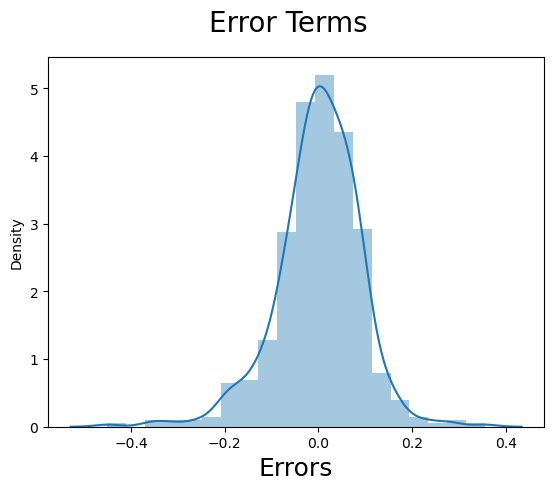

In [343]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

**Conclusion**:
The histogram above shows that the error terms are normally distributed with mean centered around 0.

#### 8.2 Plot the scatter plot of residulas of every data to understand the spread

In [346]:
res = y_train - y_train_pred
res

728   -0.187918
541    0.067033
116    0.015154
718   -0.136108
496    0.085727
         ...   
590   -0.017403
55    -0.030812
356   -0.017053
82    -0.031800
532    0.104420
Length: 501, dtype: float64

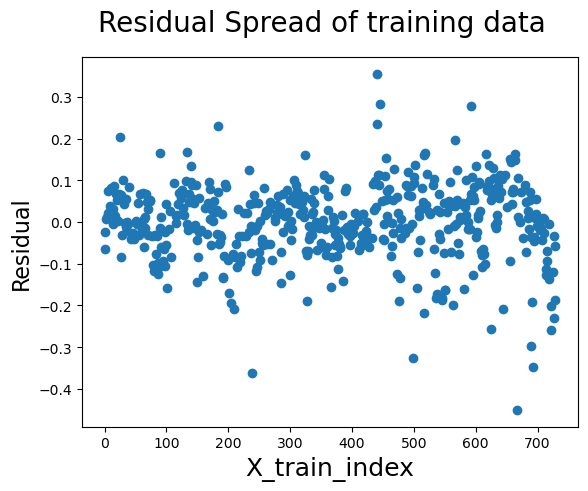

In [347]:
fig = plt.figure()
plt.scatter(X_train.index,res)
fig.suptitle('Residual Spread of training data', fontsize=20)  
plt.xlabel('X_train_index', fontsize=18)                          # X-label
plt.ylabel('Residual', fontsize=16)                          # Y-label
plt.show()

**Conclusion**:
The scatter plot above shows that the residuals are centered around 0. There is no major variance in the spread as well. Its mostly **Homoskedastic**

### Step 9: Making Predictions & Evaluation of the model

#### Dividing test data into X_test and y_test

In [240]:
y_test = df_test.pop('cnt')
X_test = df_test

KeyError: 'cnt'

In [166]:
y_test.shape

(215,)

In [168]:
X_test.shape

(215, 30)

In [170]:
X_test_sm = sm.add_constant(X_test)

In [172]:
X_test_sm.shape

(215, 31)

In [174]:
X_test_sm[X_train_selected.columns]

,const,yr,workingday,atemp,hum,season_spring,season_winter,mnth_jan,mnth_nov,mnth_sep,weekday_sat,weathersit_cloudy,weathersit_lightRain
583,1.0,1,1,0.827713,0.627290,0,0,0,0,0,0,1,0
493,1.0,1,1,0.634223,0.688567,0,0,0,0,0,0,1,0
294,1.0,0,0,0.463565,0.514214,0,1,0,0,0,1,0,0
157,1.0,0,1,0.771951,0.466836,0,0,0,0,0,0,0,0
670,1.0,1,1,0.370630,0.351863,0,1,0,1,0,0,0,0
400,1.0,1,0,0.248161,0.603286,1,0,0,0,0,0,1,0
413,1.0,1,0,0.369804,0.370815,1,0,0,0,0,1,0,0
257,1.0,0,1,0.635087,0.635503,0,0,0,0,1,0,1,0
162,1.0,0,0,0.755057,0.694252,0,0,0,0,0,0,0,0
216,1.0,0,1,0.772777,0.516740,0,0,0,0,0,0,0,0


In [176]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test_sm[X_train_selected.columns]

In [178]:
X_train_selected.shape

(501, 13)

In [180]:
X_test_new.shape

(215, 13)

In [182]:
y_test_pred = linear_model_6.predict(X_test_new)

In [184]:
print(y_train_pred.shape)
print(y_test_pred.shape)

(501,)
(215,)


In [186]:

r2_train = r2_score(y_train, y_train_pred)
print(r2_train)

0.8408472940368674


In [188]:
r2_test = r2_score(y_test, y_test_pred)
print(r2_test)

0.7862861470738751


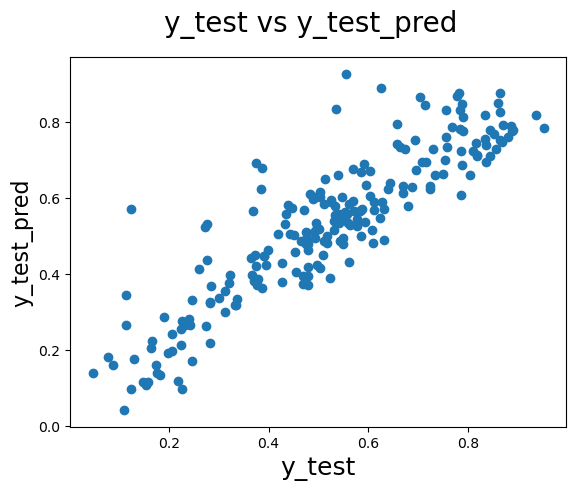

In [190]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)                          # Y-label
plt.show()